In [269]:
from google.colab import files

import tensorflow as tf

from keras import *
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
from sklearn.metrics import accuracy_score

import os
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

#Install xxd if it is not available
!apt-get -qq install xxd

Selecting previously unselected package xxd.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.4_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.4) ...
Setting up xxd (2:8.0.1453-1ubuntu1.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [2]:
#Subimos el archivo de nuestro ordenador a Google Colab
#El archivo que vamos a subir es Datos_Posiciones.txt

uploaded = files.upload()

Saving Input_Final_NN.txt to Input_Final_NN.txt


In [3]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [4]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

####**TRATAMIENTO DE LOS DATOS**

En este bloque lo que se hace es que el fichero de datos Input_Final_NN.txt queda transformado en una matriz de números en coma flotante de 32 bits, para así ser posteriormente tratados con comodidad en Python. Los separaremos en dos bloques de datos, de entrenamiento (que posteriormente serán separados también como datos de validación) y de test, para comprobar el rendimiento de la red tras su entrenamiento.

In [213]:
#Vamos a obtener los datos del fichero .txt y los vamos a pasar a una matriz
#Tener cuidado con la ultima fila del archivo subido, si es un espacio en blanco
#dara problemas

file_name = 'Input_Final_NN.txt'

data = uploaded[file_name].decode("utf-8").split("\r\n")

columnas = 16

for i in range(len(data)):
  data[i] = np.array(data[i].split("  "))

data_matrix = np.zeros((len(data), columnas), dtype="float32")

for i in range(len(data)-1):
  for j in range(columnas):
    data_matrix[i][j] = data[i][j].astype(np.float32)

In [214]:
#Con la matriz de la celda anterior vamos a obtener dos matrices
#Matriz con las posiciones: entradas de la red neuronal
#Matriz con las etiquetas de cada posicion: salidas de la red neuronal

np.random.shuffle(data_matrix)

input = np.zeros((len(data), 7))
input = data_matrix[:,:7]
train_position = input[:int(len(input)*0.77),:]
test_position = input[int(len(input)*0.77):,:]

output = np.zeros((len(data), 9))
output = data_matrix[:,7:]
train_labels = output[:int(len(output)*0.77),:]
test_labels = output[int(len(output)*0.77):,:]

###**CONSTRUCCIÓN Y COMPILADO DEL MODELO**

En este bloque entrenamos la red neuronal. El único añadido es el callback, una función que lo que hace es que fuerza la parada del entrenamiento cuando llegue a un threshold (que nosotros fijaremos previamente)

In [215]:
#Creamos la arquitectura de nuestra red neuronal

nn = [7, 600, 600, 9]  # número de neuronas por capa

model = Sequential(
    [
      
        layers.Dense(nn[1], input_dim=nn[0], activation = 'relu', name = "HiddenLayer1"),
        layers.Dense(nn[2], input_dim=nn[0], activation = 'relu', name = "HiddenLayer2"),
        #layers.Dense(nn[3], input_dim=nn[0], activation = 'relu', name = "HiddenLayer3"),
        #layers.Dense(nn[4], input_dim=nn[0], activation = 'relu', name = "HiddenLayer4"),
        layers.Dense(nn[3], activation = 'sigmoid',  name = "OutputLayer"),
    ]
)

model.summary() #resumen de la arquitectura de la red

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
HiddenLayer1 (Dense)         (None, 600)               4800      
_________________________________________________________________
HiddenLayer2 (Dense)         (None, 600)               360600    
_________________________________________________________________
OutputLayer (Dense)          (None, 9)                 5409      
Total params: 370,809
Trainable params: 370,809
Non-trainable params: 0
_________________________________________________________________


In [216]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [219]:
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 1e-7),
               metrics = ['accuracy'])

my_callback = MyThresholdCallback(threshold = 0.94)

In [220]:
entrenamiento = model.fit(train_position, train_labels,
                validation_split = 0.20, 
                epochs = 1000,
                callbacks = [my_callback],
                #verbose = 0
                )

Epoch 1/1000
770/770 [==============================] - 6s 7ms/step - loss: 0.7004 - accuracy: 0.0482 - val_loss: 0.6907 - val_accuracy: 0.0510
Epoch 2/1000
770/770 [==============================] - 5s 7ms/step - loss: 0.7124 - accuracy: 0.0571 - val_loss: 0.6889 - val_accuracy: 0.0521
Epoch 3/1000
770/770 [==============================] - 5s 7ms/step - loss: 0.6886 - accuracy: 0.0571 - val_loss: 0.6870 - val_accuracy: 0.0545
Epoch 4/1000
770/770 [==============================] - 6s 7ms/step - loss: 0.6898 - accuracy: 0.0639 - val_loss: 0.6852 - val_accuracy: 0.0906
Epoch 5/1000
770/770 [==============================] - 6s 7ms/step - loss: 0.6911 - accuracy: 0.1083 - val_loss: 0.6835 - val_accuracy: 0.1534
Epoch 6/1000
770/770 [==============================] - 6s 7ms/step - loss: 0.6973 - accuracy: 0.1719 - val_loss: 0.6817 - val_accuracy: 0.1977
Epoch 7/1000
770/770 [==============================] - 5s 7ms/step - loss: 0.6941 - accuracy: 0.2040 - val_loss: 0.6799 - val_accuracy:

In [221]:
MODEL_NAME = "Hand_Recognition.h5"
model.save(MODEL_NAME)

###**RESULTADOS DEL ENTRENAMIENTO**

In [222]:
#Obtenemos la precisión y las pérdidas del modelo evaluando los datos de test

test_loss, test_acc = model.evaluate(test_position,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

convert_bytes(get_file_size(MODEL_NAME), "MB")

288/288 - 1s - loss: 0.0400 - accuracy: 0.8062

Test accuracy: 0.8062167167663574
File size: 4.275 Megabytes


In [264]:
#Función para hacer una predicción, para ver qué resultados obtenemos (más allá de que nos diga la precisión)

prediccion = model.predict(test_position)

In [268]:
#Guardar en variables los paramtetros de entrenamiento de la red
acc_train = entrenamiento.history['accuracy']
acc_test = entrenamiento.history['val_accuracy']

loss_train = entrenamiento.history['loss']
loss_test = entrenamiento.history['val_loss']

weights_list = model.get_weights()

Text(0, 0.5, 'Accuracy')

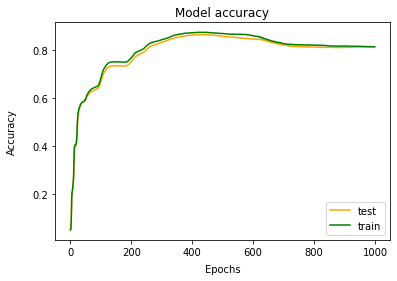

In [224]:
plt.title('Model accuracy')
plt.plot(acc_train, color = 'orange', label = 'train')
plt.plot(acc_test, color = 'green', label = 'test')
plt.legend(['test', 'train'], loc='lower right')
plt.xlabel('Epochs', labelpad = 7)
plt.ylabel('Accuracy', labelpad = 15)

Text(0, 0.5, 'Loss')

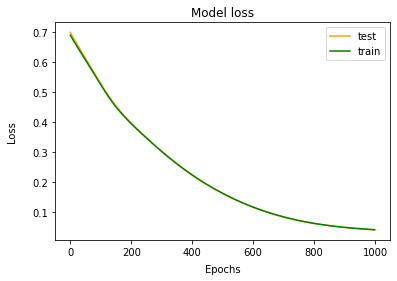

In [225]:
plt.title('Model loss')
plt.plot(loss_train, color = 'orange', label = 'train')
plt.plot(loss_test, color = 'green', label = 'test')
plt.legend(['test', 'train'], loc='upper right')
plt.xlabel('Epochs', labelpad = 7)
plt.ylabel('Loss', labelpad = 15)

###**MODELO SIN OPTIMIZAR**

In [226]:
TF_LITE_MODEL_WITHOUT_OPT = "Hand_Recognition_Without_Opt.tflite"

In [227]:
#Convertimos el modelo de TF a TFLite

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_without_optimization = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp08qx38g3/assets


INFO:tensorflow:Assets written to: /tmp/tmp08qx38g3/assets


In [228]:
#Lo escribimos como una matriz de caracteres

tflite_model_without_opt_name = TF_LITE_MODEL_WITHOUT_OPT
open(tflite_model_without_opt_name, "wb").write(tflite_model_without_optimization)

1485108

In [229]:
#Celda para comprobar la entrada y salida de la red

interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_WITHOUT_OPT)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [1 7]
Input Type: <class 'numpy.float32'>
Output Shape: [1 9]
Output Type: <class 'numpy.float32'>


In [230]:
#Celda para hacer un reshape para que posteriormente podamos comprobar la precison del modelo de TFLite
#LAS CELDAS POSTERIORES SON UN CODIGO PARA CALCULAR ESA PRECISION ADAPTADO PARA NUESTRO PROBLEMA CON LA RED FULLY CONNECTED

interpreter.resize_tensor_input(input_details[0]['index'], (len(test_position), 7))
interpreter.resize_tensor_input(output_details[0]['index'], (len(test_labels), 9))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [9201    7]
Input Type: <class 'numpy.float32'>
Output Shape: [9201    9]
Output Type: <class 'numpy.float32'>


In [231]:
interpreter.set_tensor(input_details[0]['index'], test_position)
interpreter.invoke()
tflite_model_predictions_without_opt = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions_without_opt.shape)
prediction_classes_without_opt = np.round(tflite_model_predictions_without_opt) #REDONDEA LOS RESULTADOS OBTENIDOS POR LA RED

Prediction results shape: (9201, 9)


In [233]:
tflite_model_predictions_without_opt_aux = np.zeros((tflite_model_predictions_without_opt.shape[0], tflite_model_predictions_without_opt.shape[1]))

#BUCLE QUE LO QUE HACE ES QUE PARA LOS DEDOS/MANO OBTIENE EL MAXIMO. Y LE DA EL VALOR DE 1, MIENTRAS QUE AL RESTO LES DA 0

for i in range(tflite_model_predictions_without_opt.shape[0]):
  pos_maximo_brazo = np.argmax(tflite_model_predictions_without_opt[i,:5])
  pos_maximo_dedos = np.argmax(tflite_model_predictions_without_opt[i,5:])
  for j in range(tflite_model_predictions_without_opt.shape[1]):
    if(j < 5 and j == pos_maximo_brazo):
      tflite_model_predictions_without_opt_aux[i][j] = 1
    elif (j >= 5 and j == (pos_maximo_dedos + 5)):
      tflite_model_predictions_without_opt_aux[i][j] = 1

In [262]:
#Obtenemos la precision y el numero de bytes del modelo

tf_lite_acc = accuracy_score(tflite_model_predictions_without_opt_aux, test_labels)
print('Test accuracy TFLITE model :', tf_lite_acc)

convert_bytes(get_file_size(TF_LITE_MODEL_WITHOUT_OPT), "MB")

Test accuracy TFLITE model : 0.9675035322247582
File size: 1.416 Megabytes


###**MODELO OPTIMIZADO**

In [236]:
TF_LITE_MODEL_OPT = "Hand_Recognition_OPT.tflite"

In [237]:
#Para optimizar el modelo de TFLite necesitamos un "representative_dataset" para que lo mapee y realice la cuantizacion

representative_dataset_size = 500
representative_data= np.zeros((representative_dataset_size, 7), dtype="float32")

for i in range(representative_dataset_size):
  for j in range(7):
    representative_data[i][j] = test_position[i][j].astype(np.float32)

In [245]:
#Como antes, convertimos el modelo de TF a TFLite pero esta vez pasandole el dataset representativo

def representative_data_gen():
  for i in range(representative_dataset_size):
    yield[np.array(representative_data, dtype = 'float32', ndmin = 16)]

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]

tf_lite_converter.representative_dataset = representative_data_gen
tf_lite_model_optimized = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmplobmh1o2/assets


INFO:tensorflow:Assets written to: /tmp/tmplobmh1o2/assets


In [246]:
#Lo escribimos como una matriz de caracteres

tflite_model_name = TF_LITE_MODEL_OPT
open(tflite_model_name, "wb").write(tf_lite_model_optimized)

377008

In [247]:
#Lo mismo que antes, para comprobar entradas y salidas de la red y hacer un "reshape"

interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_OPT)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [1 7]
Input Type: <class 'numpy.float32'>
Output Shape: [1 9]
Output Type: <class 'numpy.float32'>


In [248]:
interpreter.resize_tensor_input(input_details[0]['index'], (len(test_position), 7))
interpreter.resize_tensor_input(output_details[0]['index'], (len(test_labels), 9))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [9201    7]
Input Type: <class 'numpy.float32'>
Output Shape: [9201    9]
Output Type: <class 'numpy.float32'>


In [249]:
interpreter.set_tensor(input_details[0]['index'], test_position)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.round(tflite_model_predictions) 

Prediction results shape: (9201, 9)


In [250]:
tflite_model_predictions_aux = np.zeros((tflite_model_predictions.shape[0], tflite_model_predictions.shape[1]))

for i in range(tflite_model_predictions.shape[0]):
  pos_maximo_brazo = np.argmax(tflite_model_predictions[i,:5])
  pos_maximo_dedos = np.argmax(tflite_model_predictions[i,5:])
  for j in range(tflite_model_predictions.shape[1]):
    if(j < 5 and j == pos_maximo_brazo):
      tflite_model_predictions_aux[i][j] = 1
    elif (j >= 5 and j == (pos_maximo_dedos + 5)):
      tflite_model_predictions_aux[i][j] = 1

In [253]:
#Precision y tamaño del modelo una vez optimizado

tf_lite_acc = accuracy_score(tflite_model_predictions_aux, test_labels)
print('Test accuracy TFLITE model :', tf_lite_acc)

convert_bytes(get_file_size(TF_LITE_MODEL_OPT), "MB")

Test accuracy TFLITE model : 0.9672861645473319
File size: 0.36 Megabytes


###**DESCARGA DE LOS MODELOS**

In [272]:
# Save the file as a C source file
!xxd -i Hand_Recognition_OPT.tflite > Complete_Hand_NN.cc
# Print the source file
#!cat Hand_Recognition_NN.cc

In [277]:
files.download('Hand_Recognition.h5')
files.download('Hand_Recognition_OPT.tflite')
files.download('Hand_Recognition_Without_Opt.tflite')
files.download('Complete_Hand_NN.cc')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>